In [1]:
import os
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Continue with regular imports
import matplotlib.pyplot as plt

# Try to get torchinfo for summary of model, install it if it doesn't work
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary


In [2]:
from utils.accuracy import accuracy
from utils.train_test import *

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Datatransforms

In [4]:
# All models are pretrained on IMAGENET1K

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets

In [5]:
DATA_DIR = 'brain_dataset'
SPLIT_RATIO = 0.8

# Import dataset
dataset = datasets.ImageFolder(root=DATA_DIR)

# Split dataset
train_size = int(SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Assign transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

classes = dataset.classes
len(train_dataset), len(test_dataset), classes

(201, 51, ['no', 'yes'])

# Dataloaders

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d8e69eccd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1d8e67e8d90>)

# Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

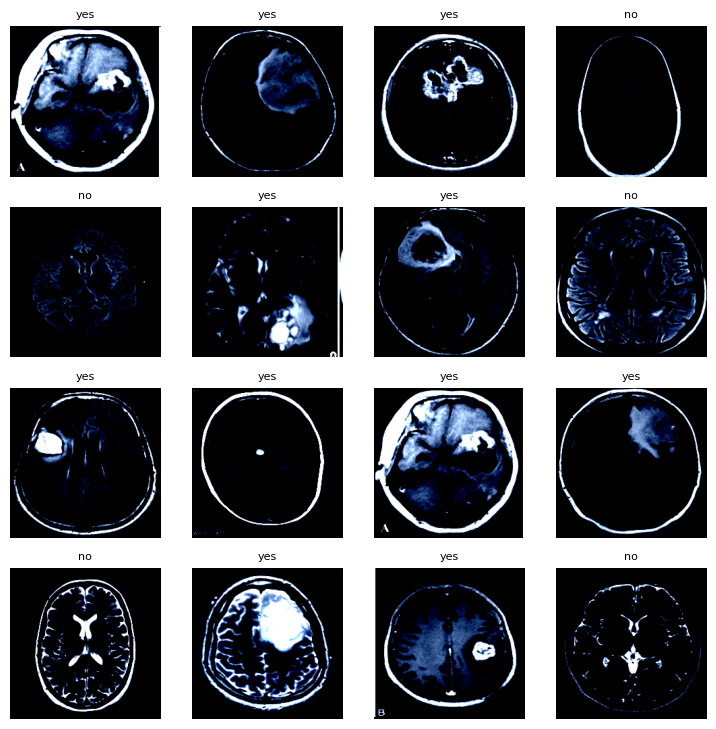

In [7]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
  image, true_label = train_dataset[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")

  plt.title(f"{classes[true_label]}", fontsize=8)
  plt.axis(False)

# Model

In [8]:
weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
model = torchvision.models.vgg16(weights=weights)
model.to(device)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    1,792                True
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    36,928               True
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   73,856               True
│    └─ReLU (6)     

# Freezing

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

for i, param in enumerate(model.classifier.parameters()):
  if i<4:
    param.requires_grad = False

#summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

# Head Update

In [11]:
model.classifier[6] = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(4096, 1))

In [12]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 1]               --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    (36,928)             False
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (

# Loss function and optimizer

In [13]:
loss_fn = nn.BCEWithLogitsLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [14]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [15]:
EPOCHS = 30

program_starts = time.time()
for epoch in tqdm(range(EPOCHS)):
  train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
  test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Training Loss: {train_loss} | Test Loss: {test_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 0.6802282333374023 | Test Loss: 0.5570052266120911 | Test acc: 66.66666666666667%
Epoch: 2 | Training Loss: 0.5352828502655029 | Test Loss: 0.5489842295646667 | Test acc: 76.47058823529412%
Epoch: 3 | Training Loss: 0.47990882396698 | Test Loss: 0.4591377377510071 | Test acc: 84.31372549019608%
Epoch: 4 | Training Loss: 0.44462767243385315 | Test Loss: 0.444007933139801 | Test acc: 86.27450980392157%
Epoch: 5 | Training Loss: 0.4415629506111145 | Test Loss: 0.41466107964515686 | Test acc: 84.31372549019608%
Epoch: 6 | Training Loss: 0.4209187626838684 | Test Loss: 0.38939496874809265 | Test acc: 86.27450980392157%
Epoch: 7 | Training Loss: 0.40312859416007996 | Test Loss: 0.396315336227417 | Test acc: 84.31372549019608%
Epoch: 8 | Training Loss: 0.4094690680503845 | Test Loss: 0.3852786719799042 | Test acc: 84.31372549019608%
Epoch: 9 | Training Loss: 0.4012843072414398 | Test Loss: 0.369618684053421 | Test acc: 84.31372549019608%
Epoch: 10 | Training Loss: 0.

# Plot

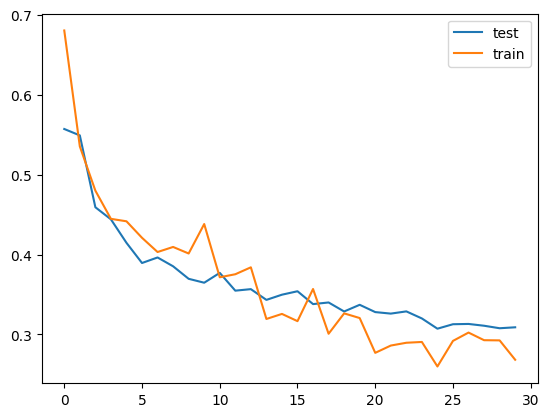

In [16]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

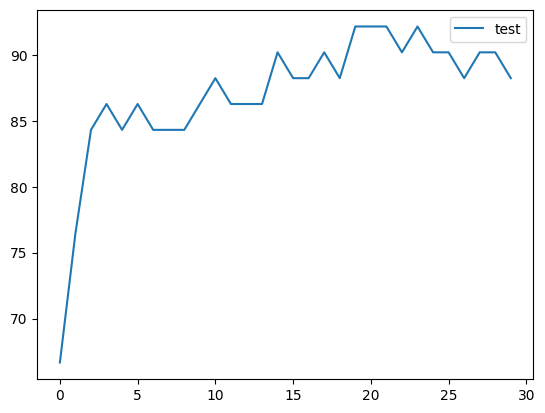

In [17]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

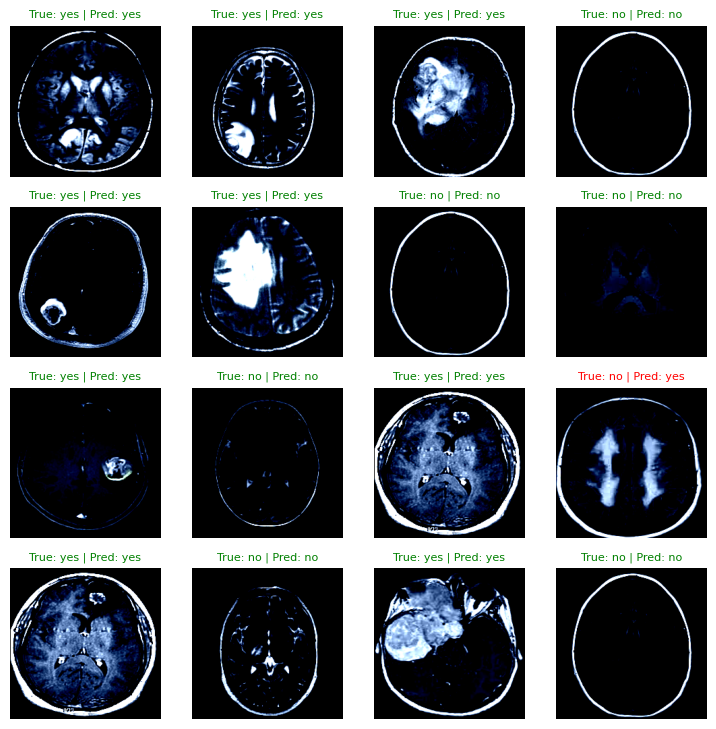

In [18]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
  image, true_label = test_dataset[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

## Confusion matrix

  0%|          | 0/51 [00:00<?, ?it/s]

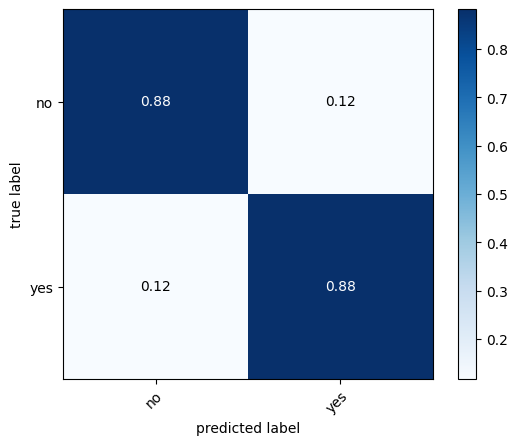

In [19]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

y_preds = []
true_labels = []

for i in tqdm(range(len(test_dataset))):
  image, true_label = test_dataset[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()
  y_preds.append(predicted_label)
  true_labels.append(true_label)

y_preds = torch.tensor(y_preds).squeeze()
true_labels = torch.tensor(true_labels).squeeze()

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
matrix = np.array(confmat(y_preds, true_labels))

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()

In [20]:
print([loss.item() for loss in train_losses])
print([loss.item() for loss in test_losses])
print(test_accuracies)
print([[int(i) for i in row]for row in matrix])

[0.6802282333374023, 0.5352828502655029, 0.47990882396698, 0.44462767243385315, 0.4415629506111145, 0.4209187626838684, 0.40312859416007996, 0.4094690680503845, 0.4012843072414398, 0.43813517689704895, 0.3715611398220062, 0.3753272593021393, 0.38399776816368103, 0.31938979029655457, 0.3257129192352295, 0.31667014956474304, 0.3568759560585022, 0.30090540647506714, 0.326396107673645, 0.32054805755615234, 0.27702370285987854, 0.2861442565917969, 0.28964418172836304, 0.2906368374824524, 0.25997498631477356, 0.2919778525829315, 0.3023768961429596, 0.29284247756004333, 0.29261645674705505, 0.2683846652507782]
[0.5570052266120911, 0.5489842295646667, 0.4591377377510071, 0.444007933139801, 0.41466107964515686, 0.38939496874809265, 0.396315336227417, 0.3852786719799042, 0.369618684053421, 0.36473581194877625, 0.3770448863506317, 0.354800820350647, 0.35669735074043274, 0.3432683050632477, 0.34976011514663696, 0.35406333208084106, 0.3379994034767151, 0.34003061056137085, 0.32875916361808777, 0.33